# Redes Neuronales 2020
## Trabajo Práctico 2
### Integrate-and-Fire

Se considera el modelo **Integrate-and-Fire** para la evolución temporal del potencial de membrana $ V_m (t) $ al tiempo $ t $ entre el interior y el exterior de una neurona genérica:

$$ \tau_m {{\partial V_m(t) }\over{ \partial t }} = E_L - V_m(t) + R_m I_e(t), $$

donde $ E_L $ es el potencial en reposo, $ I_e(t) $ es una corriente eléctrica externa (cuyo valor positivo corresponde a una corriente entrante) que se inyecta (input), $ R_m $ es la resistencia y $ \tau_m $ es el tiempo característico de la membrana $ \tau_m = r_m c_m $ (donde $ r_m $ y $ c_m $ son respectivamente la resistencia y la capacitancia de la membrana por unidad de área). Esta ecuación se puede reescribir cómo:

$$ {{\partial V_m(t) }\over{ \partial t }} = {1 \over \tau_m} ( E_L - V_m(t) + R_m I_e(t) ), $$

Consideramos:

- **mV** = miliVoltio (1/1000) de un voltio
- $ M\Omega $ = megaohms *(ohm is the resistance between two points of an electrical conductor transmitting a current of one ampere when the potential difference is one volt)*

### Imports

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from autoclass import autoargs
from scipy import integrate

# cool plots
sns.set_style("darkgrid")

# ensure reproducibility
np.random.seed(23)

### Resolución analítica

Vamos a resolver la ecuación anterior (sin considerar el umbral de disparo), para el caso de una corriente externa $ I_e $ constante y definiendo $ V_m $ como: 

$$ I_e (t) = I_e, \qquad V_m (t = 0) = V_0 $$

Luego, vamos a graficar la solución para $ 0ms \leq t \leq 200ms $ con los siguientes valores para los parámetros:

$$ V_m(t = 0) = E_L = -65mV, \qquad R = 10 M \Omega, \qquad V_{th} = -50 mV, \qquad \tau_m = 10ms \qquad I_e = 2 nA $$

La resolución analítica de la ecuación se reduce a la siguiente fórmula (más información sobre el proceso en el ):

$$ V_m(t) = (R_m I_e) (- e^{-t \over \tau_m} + 1) + E_L $$

Comenzamos definiendo una clase para manejar nuestro modelo:

In [2]:
class BaseIntegrateAndFire:
    """ Modelo Base Integrate and Fire """
    
    @autoargs
    def __init__(self, R_m=10, I_e=2, tau_m=10, E_L=-65, V0=-65, V_th=-50):
        pass
    
    """ Solución analítica sin umbral de disparo """
    def __call__(self, T):
        return (self.R_m*self.I_e)*(- np.exp(-T / self.tau_m) + 1) + self.E_L

Evaluamos nuestro modelo en los puntos $ 0ms \leq t \leq 200ms $

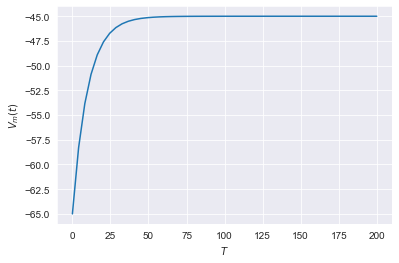

In [3]:
def ejercicio_a():
    # inicializamos el modelo y los puntos
    model = BaseIntegrateAndFire()
    T = np.linspace(0, 200)
    
    # evaluamos todos los puntos del rango temporal
    V = model(T)

    # graficamos los resultados
    plt.plot(T, V)
    plt.ylabel('$ V_m(t) $')
    plt.xlabel('$ T $')

ejercicio_a()
plt.savefig('./diagramas/grafico_a.png')

### Aproximación con Runge-Kutta

Ahora vamos a aproximar la solución al problema del valor inicial utilizando Runge-Kutta, utilizando los mismo puntos temporales y parámetros indicados en el punto anterior.

Vamos a comenzar por extender nuestra clase base de Integrate and Fire y agregar la aproximación utilizando Runge-Kutta 4.

In [4]:
class IntegrateAndFireRK4(BaseIntegrateAndFire):
    
    def dx(self, t):
        return (1 / self.tau_m) * (self.E_L - t + (self.R_m*self.I_e))

    """ Aproximación con RK4 y umbral de disparo """
    def __call__(self, T, h):
        # inicializamos las aproximaciones
        A = []
        r = self.V0

        # buscamos una aproximación para cada punto
        for i, t in enumerate(T):
            if r > self.V_th:
                r = self.V0
            A.append(r)

            p = A[i-1]
            k1 = h * self.dx(p)
            k2 = h * self.dx(p + 0.5 * k1)
            k3 = h * self.dx(p + 0.5 * k2)
            k4 = h * self.dx(p + k3)
            r += (k1 + 2*k2 + 2*k3 + k4)/6

        return np.array(A, np.float32)

Aproximamos y comparamos:

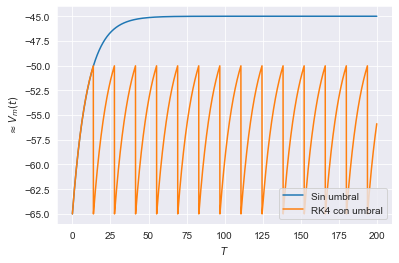

In [5]:
def ejercicio_b():
    # inicializamos los modelos
    base_model = BaseIntegrateAndFire()
    rk4_model = IntegrateAndFireRK4()
    
    # inicializamos los puntos a evaluar
    h = 0.05
    T = np.arange(0, 200, h)
    
    # evaluamos
    V_base = base_model(T)
    V_rk4 = rk4_model(T, h)
    
    # graficamos
    plt.plot(T, V_base, label='Sin umbral')
    plt.plot(T, V_rk4, label='RK4 con umbral')
    plt.xlabel('$ T $')
    plt.ylabel(r'$ \approx V_m(t) $')
    plt.legend()

ejercicio_b()
plt.savefig('./diagramas/grafico_b.png')

### Comprensión de $I_e$

Ahora vamos a variar el valor de $I_e$ entre $0 \leq I_e \leq 6$ para ver cómo varía la frecuencia de disparo.

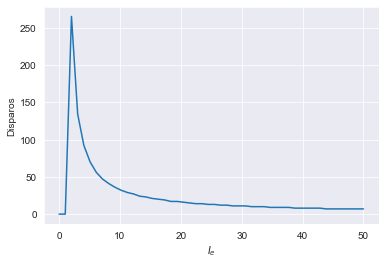

In [18]:
class IntegrateAndFireRK4IC(IntegrateAndFireRK4):
    """
    Aproximación con RK4 y umbral de disparo
    En este caso sólo vamos a continuar hasta el primer
    disparo para calcular la frecuencia de disparo,
    en términos de pasos de integración.
    """
    def __call__(self, T, h):
        # inicializamos las aproximaciones
        A = []
        freq = 0
        r = self.V0

        # buscamos una aproximación para cada punto
        for i, t in enumerate(T):
            if r > self.V_th:
                r = self.V0
                break
            A.append(r)

            freq += 1
            p = A[i-1]
            k1 = h * self.dx(p)
            k2 = h * self.dx(p + 0.5 * k1)
            k3 = h * self.dx(p + 0.5 * k2)
            k4 = h * self.dx(p + k3)
            r += (k1 + 2*k2 + 2*k3 + k4)/6
        
        # reseteamos el valor de la frecuencia
        # si nunca llegamos al valor
        if freq == len(T):
            freq = 0

        return np.array(A, np.float32), freq

def ejercicio_c():
    
    # inicializamos
    I_E = np.linspace(0, 50)
    model = IntegrateAndFireRK4IC()
    h = 0.05
    T = np.arange(0, 200, h)    
    I_e, F = [], []
    
    # iteramos y aproximamos
    for i_e in I_E:
        model.I_e = i_e
        V, freq = model(T, h)
        I_e.append(i_e)
        F.append(freq)
    
    plt.plot(I_e, F)
    plt.ylabel('Disparos')
    plt.xlabel('$I_e$')
    
ejercicio_c()
plt.savefig('./diagramas/grafico_c.png')

### $I_e$ variable

Al comienzo habíamos definido el $I_e(t)$ como una función que depende de $t$, luego, para poder encontrar una solución analítica pasamos a tomar $I_e(t) = I_e$ como una constante. Ahora vamos a variar a $I_e$ de manera uniforme entre $0$ y $5$, para ver cómo se comporta el modelo:

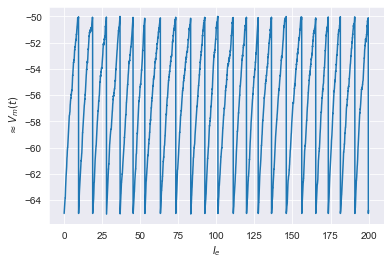

In [10]:
class IntegrateAndFireRK4IE(IntegrateAndFireRK4):
    
    def dx(self, t, i_e):
        return (1 / self.tau_m) * (self.E_L - t + (self.R_m*i_e))

    """ Aproximación con RK4, I_e variable y umbral de disparo """
    def __call__(self, T, h):
        # inicializamos las aproximaciones
        A = []
        r = self.V0

        # buscamos una aproximación para cada punto
        for i, t in enumerate(T):
            if r > self.V_th:
                r = self.V0
            A.append(r)

            p = A[i-1]
            i_e = self.I_e[i]
            
            k1 = h * self.dx(p, i_e)
            k2 = h * self.dx(p + 0.5 * k1, i_e)
            k3 = h * self.dx(p + 0.5 * k2, i_e)
            k4 = h * self.dx(p + k3, i_e)
            r += (k1 + 2*k2 + 2*k3 + k4)/6

        return np.array(A, np.float32)

def ejercicio_d():
    # inicializamos
    h = 0.05
    T = np.arange(0, 200, h)
    I_e = np.random.uniform(0, 5, len(T))
    model = IntegrateAndFireRK4IE(I_e=I_e)

    V = model(T, h)

    plt.plot(T, V)
    plt.ylabel(r'$ \approx V_m(t) $')
    plt.xlabel('$I_e$')

ejercicio_d()
plt.savefig('./diagramas/grafico_d.png')